# Visual Data Extraction using LM Format Enforcer

<a target="_blank" href="https://colab.research.google.com/github/noamgat/lm-format-enforcer/blob/main/samples/colab_llama32_vision_enforcer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook shows how you can integrate [LM Format Enforcer](https://github.com/noamgat/lm-format-enforcer) with the [Llama 3.2 Vision](https://huggingface.co/meta-llama/Llama-3.2-11B-Vision) model. It shows how you can use LMFE to extract structured output by querying images.


## Setting up the COLAB runtime (user action required)

This colab-friendly notebook is targeted at demoing the enforcer on visual LLMs. We will be using LLAMA3.2. It can run on a free GPU on Google Colab with fp4 quantization.
Make sure that your runtime is set to GPU:

Menu Bar -> Runtime -> Change runtime type -> T4 GPU (at the time of writing this notebook). [Guide here](https://www.codesansar.com/deep-learning/using-free-gpu-tpu-google-colab.htm).

In [1]:
!pip install transformers==4.45.1 torch lm-format-enforcer huggingface_hub accelerate bitsandbytes cpm_kernels pillow

# When running from source / developing the library, use this instead
# %load_ext autoreload
# %autoreload 2
# import sys
# import os
# sys.path.append(os.path.abspath('..'))
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Gathering huggingface credentials (user action required)

We begin by installing the dependencies. This demo uses llama3.2, so you will have to create a free huggingface account, request access to the llama2 model, create an access token, and insert it when executing the next cell will request it.

Links:

- [Request access to llama model](https://huggingface.co/meta-llama/Llama-3.2-11B-Vision). See the "Access Llama 3.2 on Hugging Face" section.
- [Create huggingface access token](https://huggingface.co/settings/tokens)


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Now we can create the model. This may take a few minutes. In this demo we assume you are running on free Colab, so we quaniize to 4 bit. If you are running with 24GB VRAM or more, you can set `run_in_4bit = False` to get better results.

In [2]:
import torch
from transformers import AutoConfig, AutoTokenizer, BitsAndBytesConfig
from transformers import MllamaForConditionalGeneration, AutoProcessor

model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

run_in_4bit = True  # Can set this to false if running with 24GB VRAM or more
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16) if run_in_4bit else None

device = 'cuda'

if torch.cuda.is_available():
    config = AutoConfig.from_pretrained(model_id)
    config.pretraining_tp = 1
    model = MllamaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        device_map="cuda:0",
        quantization_config=bnb_config,
    )
    processor = AutoProcessor.from_pretrained(model_id)
else:
    raise Exception('GPU not available')

tokenizer = AutoTokenizer.from_pretrained(model_id)
if tokenizer.pad_token_id is None:
    # Required for batching example
    tokenizer.pad_token_id = tokenizer.eos_token_id 


/home/noamgat/mambaforge/envs/commentranker/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


If the previous cell executed successfully, you have propertly set up your Colab runtime and huggingface account!

## Definining the desired structured output


In [3]:
from pydantic import BaseModel
from lmformatenforcer import JsonSchemaParser
from typing import List
from lmformatenforcer.integrations.transformers import build_transformers_prefix_allowed_tokens_fn, build_token_enforcer_tokenizer_data

class Brand(BaseModel):
    brands: List[str]

schema = Brand.model_json_schema()
parser = JsonSchemaParser(schema)

tokenizer_data = build_token_enforcer_tokenizer_data(processor.tokenizer, model.vocab_size)
prefix_func = build_transformers_prefix_allowed_tokens_fn(tokenizer_data, parser)


## Loading the image

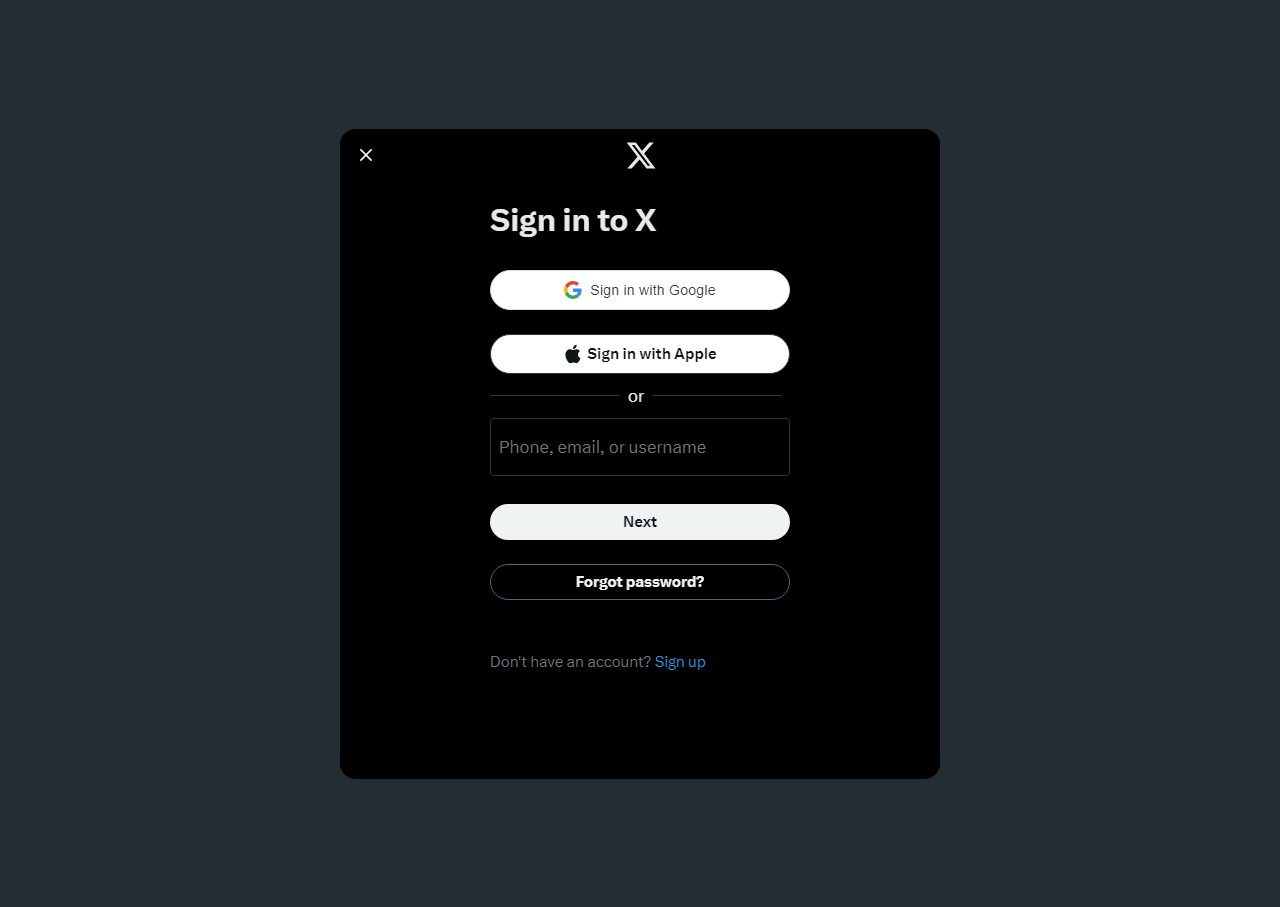

In [8]:
from PIL import Image
from urllib.request import urlopen
import io

image_path = 'https://raw.githubusercontent.com/noamgat/lm-format-enforcer/343b7902bfff0617afda4bc3dc33db089b00db23/samples/colab_llama32_vision_input.png'
fd = urlopen(image_path)
image_file = io.BytesIO(fd.read())
image = Image.open(image_file)

display(image)

## Generating structured output

In [6]:
import json
from time import time

user = '''Tell me what brands you can see on the provided screenshot, format it in json with the following format: '''

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": user+json.dumps(schema)}
    ]}
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

inputs = processor(image, input_text, return_tensors="pt").to('cuda:0')
start_generation = inputs['input_ids'].shape[1]

start_time = time()
output = model.generate(**inputs, max_new_tokens=512, prefix_allowed_tokens_fn=prefix_func)
result = processor.batch_decode(output[:, start_generation:], skip_special_tokens=True)[0]
duration = time() - start_time
display(f"Generation took {duration:.1f} seconds")

Generation took 2.1 seconds


## Viewing the result

In [7]:
display(result)

{
  "brands": [
    "Apple",
    "Google"
    "X"
  ]
}


As you can see, the result adheres to the JSON Schema, and gives us the desired information from the image!